In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from metric import recall5
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
apply_train_df = pd.read_csv('apply_train.csv')
print(len(apply_train_df.resume_seq.unique()))
print(len(apply_train_df.recruitment_seq.unique()))
apply_train_df.sort_values(['resume_seq','recruitment_seq']).reset_index(drop=True)


8482
6695


,resume_seq,recruitment_seq
0,U00001,R04536
1,U00001,R05210
2,U00001,R05288
3,U00001,R06065
4,U00002,R01103
...,...,...
57941,U08481,R05500
57942,U08481,R06253
57943,U08482,R03633
57944,U08482,R03743


C:\Users\User\AppData\Local\Temp\ipykernel_24400\2966708145.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(udata.corr())


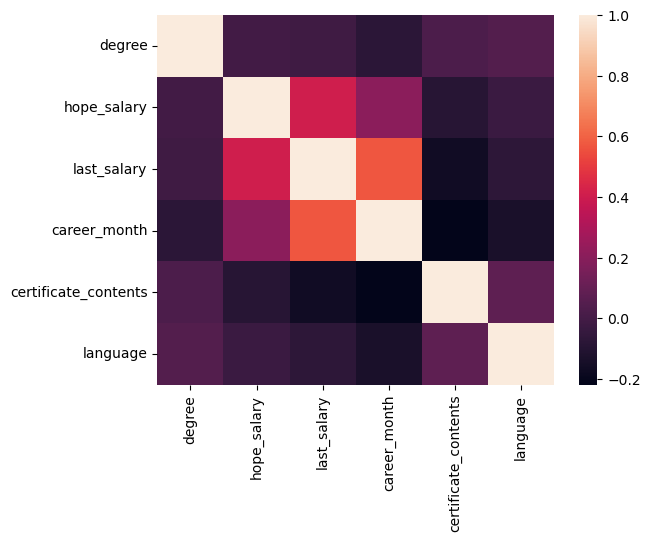

C:\Users\User\AppData\Local\Temp\ipykernel_24400\2966708145.py:53: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rdata.corr())


[0.42794063 0.18142266 0.15204147]


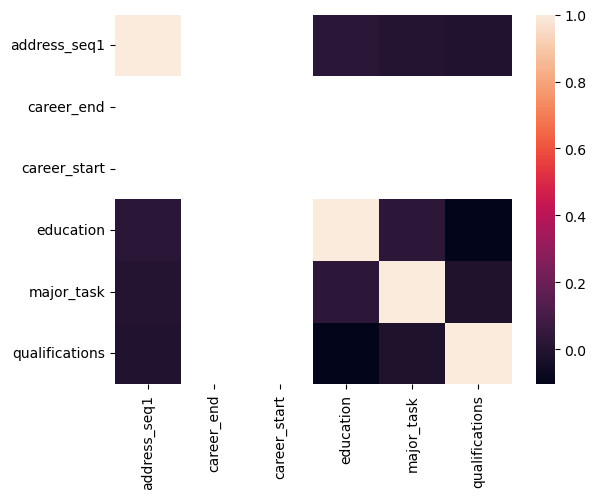

[0.50897918 0.30221199]


In [8]:
# 사용자-아이템 행렬 생성: 구직자가 해당 채용 공고에 지원했으면 1, 아니면 0으로 설정
user_item_matrix = apply_train_df.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
# user_item_matrix[user_item_matrix > 1] = 1

udata = pd.read_csv('./resume.csv')
# udata = pd.merge(udata,pd.read_csv('./resume_certificate.csv'),how='left')
droping = ['reg_date','updated_date','graduate_date','job_code_seq2','job_code_seq3']
udata = udata.drop(droping,axis=1)

encoding = ['text_keyword','job_code_seq1','career_job_code'] # + certify encoding
udata = udata.drop(encoding,axis=1)

mg = pd.read_csv('./resume_certificate.csv').groupby('resume_seq').count().reset_index()
udata = pd.merge(udata,mg,how='left').fillna(0)
mg = pd.read_csv('./resume_language.csv').loc[:,['resume_seq','language']].groupby('resume_seq').count().reset_index()
udata = pd.merge(udata,mg,how='left').fillna(0)


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
for i in udata.columns[1:]:
    scaled_data = scaler.fit_transform(np.array(udata[i]).reshape(-1,1))
    udata[i] = scaled_data
    
sns.heatmap(udata.corr())
plt.show()

n_components = 3  # Number of principal components to keep
pca = PCA(n_components)
principal_components = pca.fit_transform(udata.iloc[:,1:])
print(pca.explained_variance_ratio_)

scaled_udata = udata['resume_seq']
udata = pd.concat([scaled_udata,pd.DataFrame(principal_components,columns=['upca1','upca2','upca3'])],axis=1)

pd.read_csv('./company.csv') # r
rdata = pd.read_csv('./recruitment.csv') # r
encoding = ['address_seq2','address_seq3','check_box_keyword','text_keyword'] # encoding, merge
rdata = rdata.drop(encoding,axis=1)
rdata = rdata.fillna(3)


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
for i in rdata.columns[1:]:
    scaled_data = scaler.fit_transform(np.array(rdata[i]).reshape(-1,1))
    rdata[i] = scaled_data
    
sns.heatmap(rdata.corr())
plt.show()

n_components = 2  # Number of principal components to keep
pca = PCA(n_components)
principal_components = pca.fit_transform(rdata.iloc[:,1:])
print(pca.explained_variance_ratio_)

scaled_rdata = rdata['recruitment_seq']
rdata = pd.concat([scaled_rdata,pd.DataFrame(principal_components,columns=['rpca1','rpca2'])],axis=1)
tp = pd.merge(pd.merge(apply_train_df,rdata),udata)
tar = pd.DataFrame(index=sorted(tp['resume_seq'].unique()),columns=sorted(tp['recruitment_seq'].unique()))
tar = tar.fillna(0)
for i in range(len(tp)):
    data = tp.loc[i,:]
    tar.loc[data['resume_seq'],data['recruitment_seq']] = abs(data['upca1'])
    
# user_item_matrix = tar

# # 사용자 간의 유사성 계산
# user_similarity = cosine_similarity(user_item_matrix) # x, yT

# # 추천 점수 계산
# user_predicted_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T

100%|████████████████████████████████████████████████████████████████████████████| 6695/6695 [00:01<00:00, 5420.35it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_24400\1112135419.py:35: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rdata.corr())


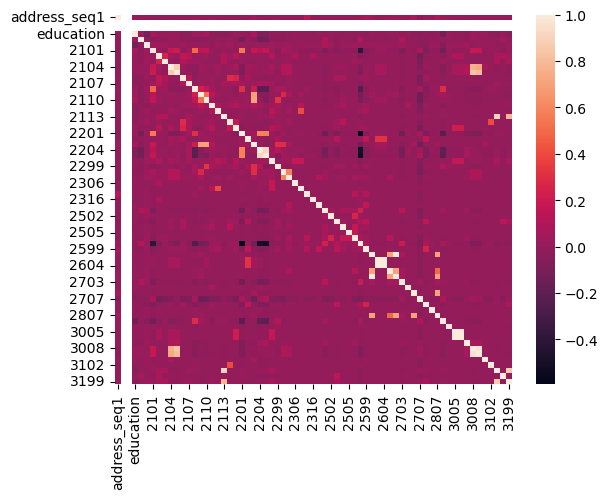

In [177]:
rdata = pd.read_csv('./recruitment.csv') # r
encoding = ['address_seq2','address_seq3','text_keyword'] # ,'check_box_keyword','text_keyword'] # encoding, merge
rdata = rdata.drop(encoding,axis=1)
rdata = rdata.fillna(3)

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the data
# for i in rdata.columns[1:]:
#     scaled_data = scaler.fit_transform(np.array(rdata[i]).reshape(-1,1))
#     rdata[i] = scaled_data
    
# sns.heatmap(rdata.corr())
# plt.show()

# n_components = 2  # Number of principal components to keep
# pca = PCA(n_components)
# principal_components = pca.fit_transform(rdata.iloc[:,1:])
# print(pca.explained_variance_ratio_)

data = [[int(j) for j in i.split(';')] for i in rdata['check_box_keyword']]
tp = []
for i in data:
    tp.extend(i)
ans = pd.DataFrame(index=range(len(data)),columns=[str(i) for i in sorted(list(set(tp)))])
for i in tqdm(range(len(data))):
    for j in data[i]:
        ans.loc[i,str(j)] = 1
            
oh = ans.fillna(0)
rdata = pd.concat([rdata,oh],axis=1)
rdata = rdata.drop('check_box_keyword',axis=1)

sns.heatmap(rdata.corr())
plt.show()
rdata.columns = rdata.columns.astype('str')
# n_comp = 30
# pca = PCA(n_components=n_comp)
# principal_components = pca.fit_transform(rdata.iloc[:,1:])
# print(sum(pca.explained_variance_ratio_))

# scaled_rdata = rdata['recruitment_seq']
# rdata = pd.concat([scaled_rdata,pd.DataFrame(principal_components,
#                                              columns=[f'rpca{i}' for i in range(61)])],
#                                              axis=1)

rdata = rdata.sort_values('recruitment_seq').reset_index(drop=True)

In [180]:
rdata

,recruitment_seq,address_seq1,career_end,career_start,education,major_task,qualifications,2101,2102,2103,...,3005,3006,3007,3008,3099,3101,3102,3103,3105,3199
0,R00001,5.0,0,0,2,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,R00002,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,R00003,3.0,0,0,3,2,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,R00004,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,R00005,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6691,R06692,3.0,0,0,3,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6692,R06693,5.0,0,0,4,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6693,R06694,3.0,0,0,4,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
# case of R00001 classification
tar = pd.DataFrame(apply_train_df.sort_values('resume_seq').groupby('resume_seq'))[1][0]['recruitment_seq']
tar = [eval(i[2:]) for i in tar]
label = [0 for _ in range(len(rdata))]
for i in tar:
    label[i] = 1
rdata['label'] = label
rdata

,recruitment_seq,address_seq1,career_end,career_start,education,major_task,qualifications,2101,2102,2103,...,3006,3007,3008,3099,3101,3102,3103,3105,3199,label
0,R00001,5.0,0,0,2,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,R00002,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,R00003,3.0,0,0,3,2,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,R00004,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,R00005,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,0,0,3,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6691,R06692,3.0,0,0,3,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6692,R06693,5.0,0,0,4,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6693,R06694,3.0,0,0,4,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold 객체 생성 (K=3)
stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
X = rdata.drop('label',axis=1)
y = rdata['label']


# 각 폴드에서 데이터를 나누고 반복
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    train = pd.concat([X_train,y_train],axis=1)
    predictor = TabularPredictor(label='label', eval_metric='accuracy').fit(train)
    # predictor.predict_proba(pd.concat([X_test,y_test]))
    print(predictor.evaluate(pd.concat([X_test,y_test],axis=1))['accuracy'])


No path specified. Models will be saved in: "AutogluonModels\ag-20231027_145037"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231027_145037"
AutoGluon Version:  0.8.2
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   266.30 GB / 494.27 GB (53.9%)
Train Data Rows:    5021
Train Data Columns: 68
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1290.88 MB
	

Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1283.87 MB
	Train Data (Original)  Memory Usage: 3.01 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 60 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...


0.9994026284348865


	Useless Original Features (Count: 3): ['career_end', 'career_start', '2316']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 13): ['recruitment_seq', '2505', '2604', '2605', '2701', '2706', '2805', '2807', '2914', '3005', '3006', '3099', '3101']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('int', [])    : 12 | ['2505', '2604', '2605', '2701', '2706', ...]
		('object', []) :  1 | ['recruitment_seq']
	Types of features in original data (raw dtype, special dtype

0.9994026284348865


	Useless Original Features (Count: 7): ['career_end', 'career_start', '2310', '2320', '2706', '3101', '3102']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 14): ['recruitment_seq', '2306', '2315', '2316', '2502', '2505', '2604', '2605', '2701', '2705', '2807', '3005', '3006', '3105']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('int', [])    : 13 | ['2306', '2315', '2316', '2502', '2505', ...]
		('object', []) :  1 | ['recruitment_seq']
	Types of features in

0.9994026284348865


		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 5): ['career_end', 'career_start', '2505', '2602', '2701']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 10): ['recruitment_seq', '2320', '2603', '2604', '2706', '2805', '2807', '2914', '3006', '3101']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('int', [])    : 9 | ['2320', '2603', '2604', '2706', '2805', ...]
		('object', []) : 1 | ['recruitment_seq']
	Types of features in origi

0.9994022713687986


In [166]:
tp = pd.read_csv('./recruitment.csv').set_index('recruitment_seq')
tp.loc[['R00273','R00697','R01045','R01293','R01538'],:]

,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword
recruitment_seq,,,,,,,,,,
R00273,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN
R00697,3.0,NaN,NaN,0,0,2101;2201;2204;2205;2707,3,2,1,NaN
R01045,3.0,NaN,NaN,0,0,2507;2707,4,2,2,NaN
R01293,3.0,NaN,NaN,0,0,2101;2201;2204;2205;2707,3,2,1,NaN
R01538,3.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2501;2507;2707,4,2,1,NaN
